# Airline Sentiment Analysis

#### Problem Statement: The task is to perform a sentiment analysis on the tweets about the problems of each major U.S. airline. The data was procured from Twitter from February 2015 and the contributers were asked to classify each tweet into one of these categories: Positive, Negative and netural tweets, following by categorizing negative reasons (such as "late flight" or "rude service").

Customer Service is one of the most important aspect of business management. Customer service is important because it inspires customer loyalty and makes employee's jobs easier. This, in turn, helps businesses grow. By providing great customer service, organizations can recover customer acquisition costs, retain talent, and foster brand loyalty. Therefore, analysing the consumer sentiment is the integral part of Customer Service. Since, in the modern world, people express their excitement, sorrows, regret, anger etc. of a public or private service using Twitter, we believe that tweets can be considered a fairly reliable source of consumer sentiment. By performing this analysis, we will be arming ourselves with key information as to how to improve the negative aspects of our Airline services, as well maintain and upgrade the positive ones. 

In [ ]:
# Regular Expression: For pre-processing of data i.e. finding and replacing patterns from strings
import re

import numpy as np
import pandas as pd
import tensorflow as tf

# Tokenizer: Used to vectorize a sequence of text
from keras.preprocessing.text import Tokenizer
# pad_sequences: This function transforms a list of integers into 2D Numpy array
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Splits entire dataset into training and testing sets based on a given percentage
from sklearn.model_selection import train_test_split
#Optimizers
from keras.optimizers import SGD, Adagrad, RMSprop, Adam
# Scikit-learn classifier implementation for Keras
from keras.wrappers.scikit_learn import KerasClassifier
# GridSearchCV: Module to compute best configurations for models
from sklearn.model_selection import GridSearchCV
# Regularizers: Used to apply penalties on layer parameters or layer activity during optimization
from keras import regularizers
# EarlyStopping: Used to stop training when a monitored metric has stopped improving in order to save time
from keras.callbacks import EarlyStopping
# Metrics: Used to evaluate and compare machine learning models
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve,auc

# NLTK: Natural Language Toolkit
import nltk
# Stopwords: Used to identify and remove common words that don't hold considerable sentiment
from nltk.corpus import stopwords
# word_tokenize: Used to convert a sentence into a sequence of words i.e. tokens
from nltk.tokenize import word_tokenize
# Used for the Stemming and Lemmatization of the tokens
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Deep learning libraries
from keras.models import Sequential
from keras.layers import Embedding

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Pre-Processing

Pre-processing is an important step in Natural Language Processing (NLP) because it helps to improve the quality of the input data and prepare it for further processing. Pre-processing is important for NLP tasks as it helps in:

Data Cleaning: Raw text data often contains noise and inconsistencies that can negatively affect the performance of NLP models. Pre-processing helps to clean the text data and remove irrelevant information.

Dimensionality Reduction: Pre-processing can help to reduce the dimensionality of the data by transforming words into their root form, removing stop words, and reducing the case sensitivity of the data. This reduces the size of the data and helps the model to learn more effectively.

Improved Performance: By removing noise and inconsistencies in the data, pre-processing can improve the performance of NLP models. This is particularly important for tasks such as sentiment analysis, where even small inconsistencies in the data can have a big impact on the model's performance.

In [ ]:
stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Remove @username
    text = re.sub(r'@\w+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)
    # Tokenize the words
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words= [lemmatizer.lemmatize(word) for word in stemmed_words]
        
    # Join the words
    text = ' '.join(lemmatized_words)
    return text

In [ ]:
# Importing the tweets data
data = pd.read_csv("Tweets.csv")
# Removing unsignificant columns
df = data[["text","airline_sentiment"]]
# Keeping "Positive" and "Negative" tweets only
df = df[df.airline_sentiment != "neutral"]

# Pre-processing the imported data
df['text'] = df['text'].apply(preprocess)

In [ ]:
# Generating 4000 dimensions vectors from each 'text' objects
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)

In [ ]:
# Isolating independent and dependent variables into separate variables
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
Y = np.array(df['airline_sentiment'] == "positive", dtype=int)

In [ ]:
# Splitting data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [1]:
def build_classifier(optimizer):
    # Creating a sequential model
    model = tf.keras.models.Sequential()

    # Embedding layer: To map the high-dimensional one-hot encoded vectors of input words in a vocabulary to low-dimensional dense vectors (word embeddings)
    model.add(tf.keras.layers.Embedding(max_features, 128, input_length=X_train.shape[1]))

    # SpatialDropout1D: Responsible for dropping out entire sequences of word vectors during each forward pass of the model. This helps in generalizing the input, so that model is less prone to be overfit.
    model.add(tf.keras.layers.SpatialDropout1D(0.5))
    
    # Added dropout parameter to drop 30% of the units for the linear transformation of the inputs
    # Added recurrent_dropout parameter to drop 30% of the units for the linear transformation of the reecurrent state
    model.add(tf.keras.layers.LSTM(196, dropout = 0.3, recurrent_dropout = 0.3 ))

    # Dropout: Eliminates 20% of the input units to help avoid overfitting
    model.add(tf.keras.layers.Dropout(0.2))

    # Dense layer: Layer with 100 neurons for attribute recognition in the text sequences
    model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
    
    # Dropout: Eliminates 20% of the input units to help avoid overfitting
    model.add(tf.keras.layers.Dropout(0.4))

    # Dense: Final layer with 2 neurons i.e. "Positive" and "Negative" with softmax activation function
    # Added the L1 regularization i.e. Lasso regression to the dense layer to additionally penalize the procured loss
    model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax,kernel_regularizer=regularizers.L1(0.01)))

    # Compiling model with given optimizer, loss and metrics
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [ ]:
model = KerasClassifier(build_fn=build_classifier)

# Defining parameter choices in the form of a dictionary
parameters = {
                'optimizer': ['RMSprop', 'Adam', 'Adamax', 'Nadam', 'Nesterov','Adagrad'],
                'batch_size': [32, 64],
                'epochs': [8, 10]
             }

C:\Users\gupta\AppData\Local\Temp\ipykernel_3256\909094409.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_classifier)


The GridSearchCV function takes as input a machine learning model, a set of hyperparameter values to search over, and a scoring metric. It then trains the model using each combination of hyperparameters and evaluates the model using the specified scoring metric. The best combination of hyperparameters is then selected based on the highest score achieved by the model. Hence, we use GridSearchCV for hyperparamter tuning.

In [ ]:
#  Defining the GridSearchCV object with the model and the given parameters
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)

In [ ]:
#  Running the Grid search on the given model
grid_search = grid_search.fit(X_train, Y_train)

# Retrieving the best parameters for the given model
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/8
404/404 [==============================] - 19s 43ms/step - loss: 0.4539 - accuracy: 0.8497
Epoch 2/8
404/404 [==============================] - 17s 43ms/step - loss: 0.2398 - accuracy: 0.9242
Epoch 3/8
404/404 [==============================] - 17s 43ms/step - loss: 0.1864 - accuracy: 0.9434
Epoch 4/8
404/404 [==============================] - 17s 43ms/step - loss: 0.1490 - accuracy: 0.9530
Epoch 5/8
404/404 [==============================] - 17s 43ms/step - loss: 0.1267 - accuracy: 0.9630
Epoch 6/8
404/404 [==============================] - 17s 42ms/step - loss: 0.1055 - accuracy: 0.9681
Epoch 7/8
404/404 [==============================] - 17s 43ms/step - loss: 0.0988 - accuracy: 0.9698
Epoch 8/8
51/51 [==============================] - 1s 9ms/step
Epoch 1/8
404/404 [==============================] - 18s 43ms/step - loss: 0.4545 - accuracy: 0.8538
Epoch 2/8
404/404 [==============================] - 17s 43ms/step - loss: 0.2400 - accuracy: 0.9197
Epoch 3/8
404/404 [=========

404/404 [==============================] - 17s 43ms/step - loss: 0.2669 - accuracy: 0.9070
Epoch 4/10
404/404 [==============================] - 17s 43ms/step - loss: 0.2465 - accuracy: 0.9126
Epoch 5/10
404/404 [==============================] - 17s 43ms/step - loss: 0.2321 - accuracy: 0.9192
Epoch 6/10
404/404 [==============================] - 17s 43ms/step - loss: 0.2221 - accuracy: 0.9259
Epoch 7/10
404/404 [==============================] - 17s 43ms/step - loss: 0.2106 - accuracy: 0.9246
Epoch 8/10
404/404 [==============================] - 17s 43ms/step - loss: 0.2056 - accuracy: 0.9290
Epoch 9/10
404/404 [==============================] - 17s 43ms/step - loss: 0.1977 - accuracy: 0.9282
Epoch 10/10
51/51 [==============================] - 1s 9ms/step
Epoch 1/10
404/404 [==============================] - 18s 43ms/step - loss: 0.4734 - accuracy: 0.8428
Epoch 2/10
404/404 [==============================] - 17s 43ms/step - loss: 0.3071 - accuracy: 0.8954
Epoch 3/10
404/404 [========

202/202 [==============================] - 18s 91ms/step - loss: 0.1273 - accuracy: 0.9635
Epoch 6/10
202/202 [==============================] - 18s 91ms/step - loss: 0.1133 - accuracy: 0.9678
Epoch 7/10
202/202 [==============================] - 18s 91ms/step - loss: 0.0963 - accuracy: 0.9745
Epoch 8/10
202/202 [==============================] - 19s 92ms/step - loss: 0.0805 - accuracy: 0.9800
Epoch 9/10
202/202 [==============================] - 19s 92ms/step - loss: 0.0785 - accuracy: 0.9785
Epoch 10/10
51/51 [==============================] - 1s 22ms/step
Epoch 1/10
202/202 [==============================] - 20s 91ms/step - loss: 0.5202 - accuracy: 0.8400
Epoch 2/10
202/202 [==============================] - 18s 90ms/step - loss: 0.3158 - accuracy: 0.8971
Epoch 3/10
202/202 [==============================] - 18s 90ms/step - loss: 0.2583 - accuracy: 0.9175
Epoch 4/10
202/202 [==============================] - 18s 90ms/step - loss: 0.2334 - accuracy: 0.9203
Epoch 5/10
202/202 [=======

In [ ]:
print("Best parameters: ", best_parameters)
print("Best accuracy: ", best_accuracy)

Best parameters:  {'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}
Best accuracy:  0.9083916255402631


Using GridSearchCV, we obtain the best configuration for our model based on the given choices of paramter values. We recieved the highest accuracy with the **RMSProp** optimizer, batch size of **32** and **10** epochs, reaching an accuracy of **90.83%**

# Ensemble Technique to Handle Imbalance dataset problem:

### Using Bagging (Bootstrapped Aggregation) ensemble technique

We use the bagging ensemble technique in order to procure a better accuracy from an aggregation of the models. Bagging is an ensemble method that trains multiple base models on different bootstrapped samples of the same data. Since each model sees a different random subset of the data, the overall ensemble is less likely to be biased towards the majority class.

In [ ]:
# Function to average the predictions of individual models
def ensemble_predict(models, X):
    predictions = [model.predict(X) for model in models]
    avg_prediction = np.average(predictions, axis=0)
    return avg_prediction

# List to store the individual models
models = []

# Number of models to train
num_models = 5

# Creating base models for the bagging ensemble algorithm
for i in range(num_models):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(max_features, 128, input_length=X_train.shape[1]),
        tf.keras.layers.SpatialDropout1D(0.5),
        tf.keras.layers.LSTM(196, dropout=0.3, recurrent_dropout=0.3),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax,kernel_regularizer=regularizers.L1(0.01))
    ])

    # Compiling the model with the given best configuration procured earlier
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    # Fitting the model
    model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.3, verbose=2)
    # Adding the model to the list
    models.append(model)


Epoch 1/10
177/177 - 20s - loss: 0.5464 - accuracy: 0.8352 - val_loss: 0.4348 - val_accuracy: 0.8700 - 20s/epoch - 111ms/step
Epoch 2/10
177/177 - 17s - loss: 0.3190 - accuracy: 0.8979 - val_loss: 0.3437 - val_accuracy: 0.8923 - 17s/epoch - 98ms/step
Epoch 3/10
177/177 - 17s - loss: 0.2604 - accuracy: 0.9163 - val_loss: 0.3307 - val_accuracy: 0.8923 - 17s/epoch - 98ms/step
Epoch 4/10
177/177 - 17s - loss: 0.2238 - accuracy: 0.9259 - val_loss: 0.2985 - val_accuracy: 0.8944 - 17s/epoch - 98ms/step
Epoch 5/10
177/177 - 17s - loss: 0.2089 - accuracy: 0.9310 - val_loss: 0.3067 - val_accuracy: 0.8973 - 17s/epoch - 98ms/step
Epoch 6/10
177/177 - 17s - loss: 0.1924 - accuracy: 0.9358 - val_loss: 0.2772 - val_accuracy: 0.8965 - 17s/epoch - 98ms/step
Epoch 7/10
177/177 - 17s - loss: 0.1866 - accuracy: 0.9369 - val_loss: 0.2843 - val_accuracy: 0.8940 - 17s/epoch - 98ms/step
Epoch 8/10
177/177 - 17s - loss: 0.1729 - accuracy: 0.9432 - val_loss: 0.2906 - val_accuracy: 0.8948 - 17s/epoch - 98ms/step

In [ ]:
# Setting up parameter for the ensemble model
batch_size = 32

# Preparing input for the ensemble model
ensemble_inputs = models[0].input
input_shape = models[0].input_shape[1:]
X = np.zeros((batch_size,) + input_shape)

# Preparing output for the ensemble model
ensemble_outputs = [model(ensemble_inputs) for model in models]
average_outputs = tf.reduce_mean(ensemble_outputs, axis=0)
average_outputs = tf.keras.layers.Lambda(lambda x: x)(average_outputs)

# Creating the final ensemble model
ensemble_model = tf.keras.models.Model(inputs=ensemble_inputs, outputs=average_outputs)

In [ ]:
# Compiling the ensemble model with suitable configurations
ensemble_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Fitting the ensemble model
history = ensemble_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.3, verbose=2)

Epoch 1/10
177/177 - 82s - loss: 0.1574 - accuracy: 0.9540 - val_loss: 0.3195 - val_accuracy: 0.8998 - 82s/epoch - 464ms/step
Epoch 2/10
177/177 - 82s - loss: 0.1496 - accuracy: 0.9568 - val_loss: 0.3392 - val_accuracy: 0.8940 - 82s/epoch - 465ms/step
Epoch 3/10
177/177 - 82s - loss: 0.1444 - accuracy: 0.9593 - val_loss: 0.3422 - val_accuracy: 0.8981 - 82s/epoch - 463ms/step
Epoch 4/10
177/177 - 82s - loss: 0.1416 - accuracy: 0.9586 - val_loss: 0.3276 - val_accuracy: 0.8936 - 82s/epoch - 464ms/step
Epoch 5/10
177/177 - 82s - loss: 0.1366 - accuracy: 0.9627 - val_loss: 0.3846 - val_accuracy: 0.8965 - 82s/epoch - 464ms/step
Epoch 6/10
177/177 - 82s - loss: 0.1306 - accuracy: 0.9641 - val_loss: 0.4071 - val_accuracy: 0.8919 - 82s/epoch - 463ms/step
Epoch 7/10
177/177 - 82s - loss: 0.1298 - accuracy: 0.9643 - val_loss: 0.3220 - val_accuracy: 0.8903 - 82s/epoch - 464ms/step
Epoch 8/10
177/177 - 82s - loss: 0.1215 - accuracy: 0.9669 - val_loss: 0.3762 - val_accuracy: 0.8915 - 82s/epoch - 464

In [ ]:
# Evaluating the ensemble model
ensemble_model.evaluate(X_test, Y_test)

109/109 [==============================] - 11s 98ms/step - loss: 0.3343 - accuracy: 0.9108


[0.3343445956707001, 0.9107710123062134]

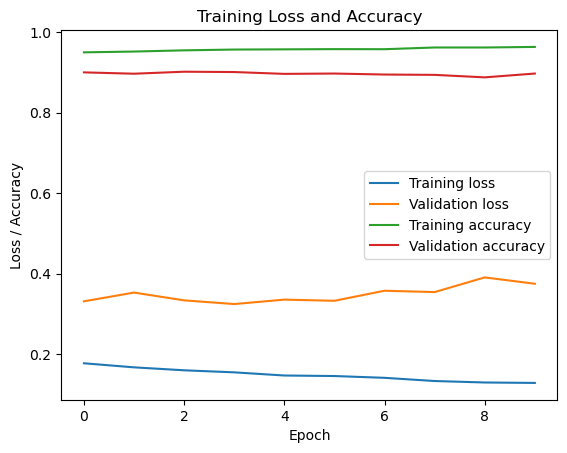

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss vs accuracy (training and validation)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.show()

In [ ]:
Y_pred = ensemble_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Getting other model metrics for the ensemble model
precision = precision_score(Y_test, Y_pred_classes)
recall = recall_score(Y_test, Y_pred_classes)
f1 = f1_score(Y_test, Y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)


109/109 [==============================] - 11s 96ms/step
Precision: 0.7769679300291545
Recall: 0.7735849056603774
F1-Score: 0.7752727272727273
AUC: 0.9451228125984286


As we observed here, by using the bagging ensemble technique, the new model is able to reach an accuracy of **91.08%**, as compared to the **90.83%** accuracy provided by the best fit model by GridSearchCV

# Cost-Sensitive Learning

Cost-Sensitive Learning is a type of machine learning that takes into account the costs of different types of errors when making predictions. For example, if the cost of false negatives (prediction is negative, but the actual label is positive) is higher than the cost of false positives (prediction is positive, but the actual label is negative), the model will adjust its decision boundary to minimize the overall cost.

The accuracy of a model is not always a good indicator of the performance of the model. It is important to consider the context and the problem that the model is trying to solve. In general, a higher accuracy is preferred, but sometimes a trade-off between accuracy and other performance measures, such as recall or precision, is necessary.


In [ ]:
def get_weights(Y):
    # Generating class weights for the binary classficiation model
    class_weights = np.zeros(2)
    for i in range(2):
        class_weights[i] = 1.0 / (sum(Y == i)/len(Y))
    return class_weights

class_weights = get_weights(Y_train)
print("Class Weights: ", class_weights)

# Compiling the Cost-sensitive learning model with required parameters
ensemble_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
sample_weight_mode="temporary", weighted_metrics=["accuracy"], loss_weights=class_weights[1])

ensemble_model.fit(X_train, Y_train, epochs=12, batch_size=64, validation_split=0.4, verbose=2)

Class Weights:  [1.26139913 4.8255675 ]
Epoch 1/12
76/76 - 60s - loss: 0.5260 - accuracy: 0.9629 - weighted_accuracy: 0.9629 - val_loss: 1.3635 - val_accuracy: 0.9112 - val_weighted_accuracy: 0.9112 - 60s/epoch - 785ms/step
Epoch 2/12
76/76 - 42s - loss: 0.4780 - accuracy: 0.9672 - weighted_accuracy: 0.9672 - val_loss: 1.3212 - val_accuracy: 0.9127 - val_weighted_accuracy: 0.9127 - 42s/epoch - 557ms/step
Epoch 3/12
76/76 - 42s - loss: 0.4880 - accuracy: 0.9693 - weighted_accuracy: 0.9693 - val_loss: 1.2754 - val_accuracy: 0.9097 - val_weighted_accuracy: 0.9097 - 42s/epoch - 557ms/step
Epoch 4/12
76/76 - 42s - loss: 0.4470 - accuracy: 0.9707 - weighted_accuracy: 0.9707 - val_loss: 1.5254 - val_accuracy: 0.9158 - val_weighted_accuracy: 0.9158 - 42s/epoch - 557ms/step
Epoch 5/12
76/76 - 42s - loss: 0.4349 - accuracy: 0.9728 - weighted_accuracy: 0.9728 - val_loss: 1.6959 - val_accuracy: 0.9016 - val_weighted_accuracy: 0.9016 - 42s/epoch - 558ms/step
Epoch 6/12
76/76 - 42s - loss: 0.4186 - 

In [ ]:
# Evaluating the Cost-sensitive learning model
score = ensemble_model.evaluate(X_test, Y_test, verbose=False)

print("loss = ", score[0])
print("accuracy = ", score[1])

loss =  1.780985951423645
accuracy =  0.9113485217094421


In [ ]:
Y_pred = ensemble_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Getting other model metrics for the Cost-Sensitive learning model
precision = precision_score(Y_test, Y_pred_classes)
recall = recall_score(Y_test, Y_pred_classes)
f1 = f1_score(Y_test, Y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)


109/109 [==============================] - 11s 94ms/step
Precision: 0.7876506024096386
Recall: 0.7590711175616836
F1-Score: 0.7730968218773095
AUC: 0.9410593181763482


Here, we observe that the Cost-sensitive learning model has given an accuracy of **89.77%** as compared to the **90.83%** accuracy of the original best fit model and the **91.08%** accuracy of the bagging ensemble model. In this case, normal accuracy (0.9083) is higher than the Cost-Sensitive Learning accuracy (0.8977), which suggests that the normal accuracy model is performing better. However, without additional information about the context, it is difficult to say for certain which model is better.

It is possible that the Cost-Sensitive Learning accuracy is lower, but the overall performance of the model is better, because it minimizes the costs associated with the errors. To determine which model is better, you would need to consider additional performance measures, such as precision, recall, F1-score, or the confusion matrix, and determine the overall trade-off between accuracy and costs.

## Conclusion

#### When it comes to choosing between these two techniques for a bagging ensemble of RNNs, it is important to consider the cost of misclassification and the degree of class imbalance in the dataset. If the cost of misclassification is high or the dataset is imbalanced, cost-sensitive learning may be a better option. However, if neither of these factors are a concern and the goal is to maximize overall accuracy, normal bagging ensemble may be sufficient.

#### Ultimately, the best approach will depend on the specific characteristics of the problem and the goals of the project. It may be useful to experiment with both techniques and compare their performance on a validation set before making a final decision. Therefore, since an imbalance exists in our airline sentiment data and the significance given to the negative reviews should be higher, the Cost-Sensitive model is the best suitable model for our problem.